## First Order Value

* Determine whether segmenting VPLifetimes on first order value improves predictions

In [1]:
import os
import pandas as pd
from tqdm import tqdm
import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('..')
from src.lifetime_dev.VPLifetimesData import VPLifetimesData
from src.lifetime_dev.VPLifetimesHoldoutPlots import VPLifetimesHoldoutPlots
from src.lifetime_dev.VPLifetimesAnalysis import VPLifetimesAnalysis
from src.lifetime_dev.VPLifetimesOrderPredictAnalyze import VPLifetimesOrderPredictAnalyze
from src.lifetime_dev.VPLifetimesHoldoutMetrics import VPLifetimesHoldoutMetrics
from pathlib import Path
from kedro.framework.context import load_context
pd.options.display.max_columns = None

start_date = '2010-07-01'
end_date = '2020-08-01'
project_path = Path(os.getcwd()).parents[0].resolve()  
context = load_context(project_path)
orders_df = context.catalog.load("ie_es_2010_2020")
orders_df.AGP_BUDGET_USD = orders_df.AGP_BUDGET_USD.astype('float64')
orders_df['ORDER_DATE_DT'] = pd.to_datetime(orders_df.ORDER_DATE, format='%Y-%m-%d')

country_field = 'ACCOUNT_CREATION_COUNTRY'
order_date_field = 'ORDER_DATE'
param_fields = ['b-r', 'b-alpha', 'b-a', 'b-b', 'g-p', 'g-q', 'g-v']
fit_results = {}
rows = []
calibration_period_end = '2019-09-30'


lifetimes version: 0.11.3
2020-08-08 15:20:45,667 - kedro.io.data_catalog - INFO - Loading data from `ie_es_2010_2020` (PickleDataSet)...


c:\users\mandersen\anaconda3\envs\py37\lib\site-packages\kedro\framework\context\context.py:538: UserWarning: Credentials not found in your Kedro project config.
No files found in ['C:\\repo\\lifetime-dev\\conf\\base', 'C:\\repo\\lifetime-dev\\conf\\local'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  str(exc)


In [2]:
def segment_first_order_value(order_df, num_buckets=4):
    """
    Mark's customers based on first order.
    Uses first AGP>0 order rather than shopper first_order_date, as AGP>0 more reliable
    and consistent withthe data.
    
    This will adjust the DataFrame passed in by adding new columns
     - ORDER_RANK (only reliable for first order)
     - FIRST_ORDER_QUARTILE
     
    Returns dataframe with these new columns added.
    
    WARNING:
    Must run this separately per country or it will introduce cross-country noise -- the quartiles
    would not be balanced within the country.
    
    Also: this will not translate into the same number of *rows* in each quantile, since more
    complex orders will be more expensive there are more orders with a high quantile than shoppers
    """
    #
    original_order_len = len(order_df)
    #
    order_sum = order_df.groupby(['SHOPPER_ID', 'ORDER_DATE_DT']).AGP_BUDGET_USD.sum().reset_index()
    order_sum['ORDER_RANK'] = order_sum.groupby(['SHOPPER_ID']).ORDER_DATE_DT.rank(method='min')
    first_orders = order_sum[order_sum.ORDER_RANK==1.0]
    first_orders['FO_AGP_QUARTILE'] = pd.qcut(first_orders.AGP_BUDGET_USD, q=num_buckets, 
                                              labels=range(num_buckets))
    # print('confirming even split for shoppers:')
    # print(first_orders.FO_AGP_QUARTILE.value_counts())
    order_df = order_df.merge(first_orders[['SHOPPER_ID', 'FO_AGP_QUARTILE']], how='inner', on='SHOPPER_ID')
    final_order_len = len(order_df)

    assert final_order_len == original_order_len, \
        f'Data merge issue length should be {original_order_len} but is now {final_order_len}'
    return order_df


In [3]:
def score_dataframe(df, cohort_name, descriptor, file_base_name, model_type, calibration_period_end, obs_date):
    """
    scores dataframe: returns df with the scores and a results dictionary
    
    df: dataset to score
    cohort_name: how to name cohort
    descriptor: title for describing
    file_base_name: filename for naming
    model_type: type of predictor
    calibration_period_end: string for date
    obs_date: string for date
    """
    print(f'Scores for {descriptor}')
    life_data = VPLifetimesData(df)

    #
    # Copied manner of doing this I had before
    # can refine
    #
    vp_lifetime_analysis = VPLifetimesAnalysis(life_data)
    vplop = VPLifetimesOrderPredictAnalyze(life_data,
                                           calibration_period_end=calibration_period_end,
                                           observation_period_end=obs_date)
    fit_params, _, _ = vplop.calibration(vp_lifetime_analysis, model_type, 0.0)
    _ = vplop.calc_order_predictions(vp_lifetime_analysis)

    if False:
        #
        # extra processing time to make graphs
        #
        plots = VPLifetimesHoldoutPlots(vplop.calholddata)


        # uncomment later if needed
        # plots.plot_default_lifetimes_charts_prob_alive(vp_lifetime_analysis.order_model, descriptor)

        # two custom charts
        plots.plot_holdout_frequency_charts(suptitle=f'Frequency holdouts: {descriptor}')
        plt.show()
        plots.plot_model_rank_vs_holdout(suptitle=f'Rank v. holdout: {descriptor}')
        plt.show()

    #
    # Use new code to get scores
    #
    temp = vplop.calholddata.copy()
    temp = temp.reset_index()
    temp.rename(columns={'model_prediction_bookings': 'predict_total_spend',
                         'model_predictions': 'predict_order_count',
                         'SHOPPER_ID': 'id'}, inplace=True)

    # disregard predict_spend_per_order -- not used in any metrics
    # but it is expected in the future.

    # pare down the columns to avoid conflict based renames on merge
    comparison = VPLifetimesHoldoutMetrics(temp[['id', 'frequency_holdout', 'monetary_value_holdout']],
                                         temp[['id', 'predict_order_count', 'predict_total_spend']])

    results = {
        'country': country,
        'cohort': cohort_name,
        'start_date': start_date,
        'obs_date': obs_date,
        'calibration_period_end': calibration_period_end,
        'num_shoppers': len(temp)
    }
    for key in fit_params:
        results[key] = fit_params[key]
    for key in comparison.base_metrics:
        results[key] = comparison.base_metrics[key]
    return temp, results


In [4]:
import numpy as np
pd.options.display.max_columns = None
countries = ['IE', 'ES']
obs_date = end_date
model_type = 'ModifiedBetaGeo'
model_results = []
country_combined = {}
combo_comparisons = {}
base_dfs = {}
combo_results = []
for country in countries:
    country_df = orders_df[orders_df[country_field] == country].copy()
    country_df = segment_first_order_value(country_df)
    
    # Baseline Metric - Whole Data Set
    descriptor = f'{country}-cal:{calibration_period_end}-obs thru:{obs_date} ModelType:{model_type} base'
    file_base_name = f'{country}-calend-{calibration_period_end}-obs-{obs_date}-model-{model_type}-base'
    base_dfs[country], results = score_dataframe(country_df, 'base', descriptor, file_base_name, model_type, calibration_period_end, obs_date)
    model_results.append(results)
    
    dfs = []
    for agp_quartile in np.arange(0, 4):
        df = country_df[country_df.FO_AGP_QUARTILE == agp_quartile]
    
        #descriptor = f'{country}-cal:{calibration_period_end}-obs thru:{obs_date} ModelType:{model_type} freq:{freq}'
        descriptor = f'{country} - FO AGP Quartile {agp_quartile}'
        df_result, results = score_dataframe(df, str(agp_quartile), 
                                     descriptor, file_base_name, model_type, calibration_period_end, obs_date)
        dfs.append(df_result)
        model_results.append(results)
    country_combined[country] = pd.concat(dfs)

    # combined analysis
    combo = country_combined[country]
    gt = combo[['id', 'frequency_holdout', 'monetary_value_holdout']]
    predictions = combo[['id', 'predict_order_count', 'predict_total_spend']]
    combo_comparison = VPLifetimesHoldoutMetrics(gt, predictions)
    results = {
        'country': country,
        'cohort': f'agp_quartiles: combined',
        'start_date': start_date,
        'obs_date': obs_date,
        'calibration_period_end': calibration_period_end,
        'num_shoppers': len(combo)
    }
    # fit_params make no sense for combined model so skipped
    for key in combo_comparison.base_metrics:
        results[key] = combo_comparison.base_metrics[key]
    combo_results.append(results)

results_df = pd.DataFrame.from_dict(model_results)
combo_results_df = pd.DataFrame.from_dict(combo_results)
combo_results_df


Scores for IE-cal:2019-09-30-obs thru:2020-08-01 ModelType:ModifiedBetaGeo base
2020-08-08 15:21:05,826 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 348174
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-08 15:21:12,481 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 126075 subjects, p: 1.85, q: 4.10, v: 50.29>
Scores for IE - FO AGP Quartile 0
2020-08-08 15:21:15,418 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 88234
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-08 15:21:16,867 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 28994 subjects, p: 1.69, q: 4.17, v: 39.80>
Scores for IE - FO AGP Quartile 1
2020-08-08 15:21:19,125 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 85687
Model type set to ModifiedBetaGeo.  Fit r

country                   cohort  start_date    obs_date  \
0      IE  agp_quartiles: combined  2010-07-01  2020-08-01   
1      ES  agp_quartiles: combined  2010-07-01  2020-08-01   

  calibration_period_end  num_shoppers  numorder_mae  numorder_rmse  \
0             2019-09-30        348174      0.117153       0.324339   
1             2019-09-30        896267      0.100795       0.298448   

   numorder_predicted_orders  numorder_actual_orders  ...  \
0               32037.476959                 21480.0  ...   
1               69544.088526                 60369.0  ...   

   mval_predicted_per_customer  mval_actual_per_customer  mval_rspearman  \
0                     3.007466                  1.292701        0.237521   
1                     2.171620                  1.221754        0.299105   

   cond_mon_mae  cond_mon_rmse  cond_mon_predicted_mean  cond_mon_actual_mean  \
0     18.207122      46.773217                17.395234             28.788852   
1     14.521049      28.307206                14.071965             23.606647   

   cond_mon_predicted_per_customer  cond_mon_actual_per_customer  \
0                        31.753216                     24.543287   
1                        26.796235                     20.669664   

   cond_mon_rspearman  
0            0.316671  
1            0.421448  

[2 rows x 27 columns]

## Higher Value FO shoppers have better predictive models thanlower value FO shoppers

In [5]:
pd.options.display.max_columns = None
results_df

country cohort  start_date    obs_date calibration_period_end  num_shoppers  \
0      IE   base  2010-07-01  2020-08-01             2019-09-30        348174   
1      IE      0  2010-07-01  2020-08-01             2019-09-30         88234   
2      IE      1  2010-07-01  2020-08-01             2019-09-30         85687   
3      IE      2  2010-07-01  2020-08-01             2019-09-30         86759   
4      IE      3  2010-07-01  2020-08-01             2019-09-30         87494   
5      ES   base  2010-07-01  2020-08-01             2019-09-30        896267   
6      ES      0  2010-07-01  2020-08-01             2019-09-30        228133   
7      ES      1  2010-07-01  2020-08-01             2019-09-30        222979   
8      ES      2  2010-07-01  2020-08-01             2019-09-30        222591   
9      ES      3  2010-07-01  2020-08-01             2019-09-30        222564   

        b-r     b-alpha       b-a       b-b       g-p       g-q        g-v  \
0  0.633934  196.690421  1.391678  1.402330  1.845397  4.101726  50.288701   
1  0.480624  164.548319  1.631272  1.644029  1.693327  4.167900  39.801167   
2  0.617942  210.026361  1.435007  1.333560  2.272188  4.431405  37.689264   
3  0.705216  226.450328  1.340330  1.308767  2.159200  5.239100  57.543958   
4  0.757888  198.930359  1.323951  1.531383  2.050408  4.526658  69.281175   
5  0.949944  258.613020  1.302610  0.987813  1.437294  4.186458  54.968605   
6  0.903171  231.049595  1.470637  0.908076  1.207139  4.606670  46.269354   
7  0.986256  294.539763  1.390134  0.928277  1.842674  5.074766  42.435060   
8  0.988492  290.045096  1.284835  1.009014  1.988823  5.785333  58.131527   
9  0.928094  235.620911  1.201569  1.246742  1.890825  4.804202  72.573684   

   numorder_mae  numorder_rmse  numorder_predicted_orders  \
0      0.117511       0.324480               32134.972801   
1      0.097695       0.285367                6387.603830   
2      0.113071       0.306750                7346.754198   
3      0.120063       0.319592                8261.711124   
4      0.137888       0.378231               10041.407807   
5      0.100308       0.298353               68791.108711   
6      0.060159       0.215932               10225.716625   
7      0.093305       0.269935               15084.233393   
8      0.113091       0.320513               19133.813770   
9      0.137655       0.367634               25100.324738   

   numorder_actual_orders  numorder_predicted_per_customer  \
0                 21480.0                         0.092296   
1                  4249.0                         0.072394   
2                  4947.0                         0.085739   
3                  5491.0                         0.095226   
4                  6793.0                         0.114767   
5                 60369.0                         0.076753   
6                  9153.0                         0.044823   
7                 13361.0                         0.067649   
8                 16537.0                         0.085960   
9                 21318.0                         0.112778   

   numorder_actual_per_customer  numorder_rspearman  mval_mae  mval_rmse  \
0                      0.061693            0.241329  3.329733  14.633507   
1                      0.048156            0.203061  2.012733   7.156351   
2                      0.057733            0.227216  2.595337   7.942949   
3                      0.063290            0.245676  3.302738  11.636988   
4                      0.077640            0.281180  5.312501  24.772693   
5                      0.067356            0.303395  2.352187  10.291491   
6                      0.040121            0.251363  0.928722   4.403427   
7                      0.059920            0.287301  1.660693   6.346458   
8                      0.074293            0.308330  2.510726   9.825928   
9                      0.095784            0.344344  4.536454  16.815224   

   mval_predicted   mval_actual  mval_predicted_per_custome

In [6]:
pd.options.display.max_columns = None
compare_df = pd.concat([combo_results_df, results_df[combo_results_df.columns]])
compare_df = compare_df.sort_values(['country', 'cohort'])
compare_df

country                   cohort  start_date    obs_date  \
6      ES                        0  2010-07-01  2020-08-01   
7      ES                        1  2010-07-01  2020-08-01   
8      ES                        2  2010-07-01  2020-08-01   
9      ES                        3  2010-07-01  2020-08-01   
1      ES  agp_quartiles: combined  2010-07-01  2020-08-01   
5      ES                     base  2010-07-01  2020-08-01   
1      IE                        0  2010-07-01  2020-08-01   
2      IE                        1  2010-07-01  2020-08-01   
3      IE                        2  2010-07-01  2020-08-01   
4      IE                        3  2010-07-01  2020-08-01   
0      IE  agp_quartiles: combined  2010-07-01  2020-08-01   
0      IE                     base  2010-07-01  2020-08-01   

  calibration_period_end  num_shoppers  numorder_mae  numorder_rmse  \
6             2019-09-30        228133      0.060159       0.215932   
7             2019-09-30        222979      0.093305       0.269935   
8             2019-09-30        222591      0.113091       0.320513   
9             2019-09-30        222564      0.137655       0.367634   
1             2019-09-30        896267      0.100795       0.298448   
5             2019-09-30        896267      0.100308       0.298353   
1             2019-09-30         88234      0.097695       0.285367   
2             2019-09-30         85687      0.113071       0.306750   
3             2019-09-30         86759      0.120063       0.319592   
4             2019-09-30         87494      0.137888       0.378231   
0             2019-09-30        348174      0.117153       0.324339   
0             2019-09-30        348174      0.117511       0.324480   

   numorder_predicted_orders  numorder_actual_orders  \
6               10225.716625                  9153.0   
7               15084.233393                 13361.0   
8               19133.813770                 16537.0   
9               25100.324738                 21318.0   
1               69544.088526                 60369.0   
5               68791.108711                 60369.0   
1                6387.603830                  4249.0   
2                7346.754198                  4947.0   
3                8261.711124                  5491.0   
4               10041.407807                  6793.0   
0               32037.476959                 21480.0   
0               32134.972801                 21480.0   

   numorder_predicted_per_customer  numorder_actual_per_customer  \
6                         0.044823                      0.040121   
7                         0.067649                      0.059920   
8                         0.085960                      0.074293   
9                         0.112778                      0.095784   
1                         0.077593                      0.067356   
5                         0.076753                      0.067356   
1                         0.072394                      0.048156   
2                         0.085739                      0.057733   
3                         0.095226                      0.063290   
4                         0.114767                      0.077640   
0                         0.092016                      0.061693   
0                         0.092296                      0.061693   

   numorder_rspearman  mval_mae  mval_rmse  mval_predicted   mval_actual  \
6            0.251363  0.928722   4.403427    1.788538e+05  1.220299e+05   
7            0.287301  1.660693   6.346458    3.142281e+05  1.931584e+05   
8            0.308330  2.510726   9.825928    4.917066e+05  2.837912e+05   
9            0.344344  4.536454  16.815224    9.615625e+05  4.960385e+05   
1            0.303696  2.399607  10.447397    1.946351e+06  1.095018e+06   
5            0.303395  2.352187  10.291491    1.879914e+06  1.095018e+06   
1            0.203061  2.012733   7.156351    1.503334e+05  7.069004e+04   
2            0.227216  2.595337   7.942949    1.9

..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))
..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))
..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))
..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))
..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((al

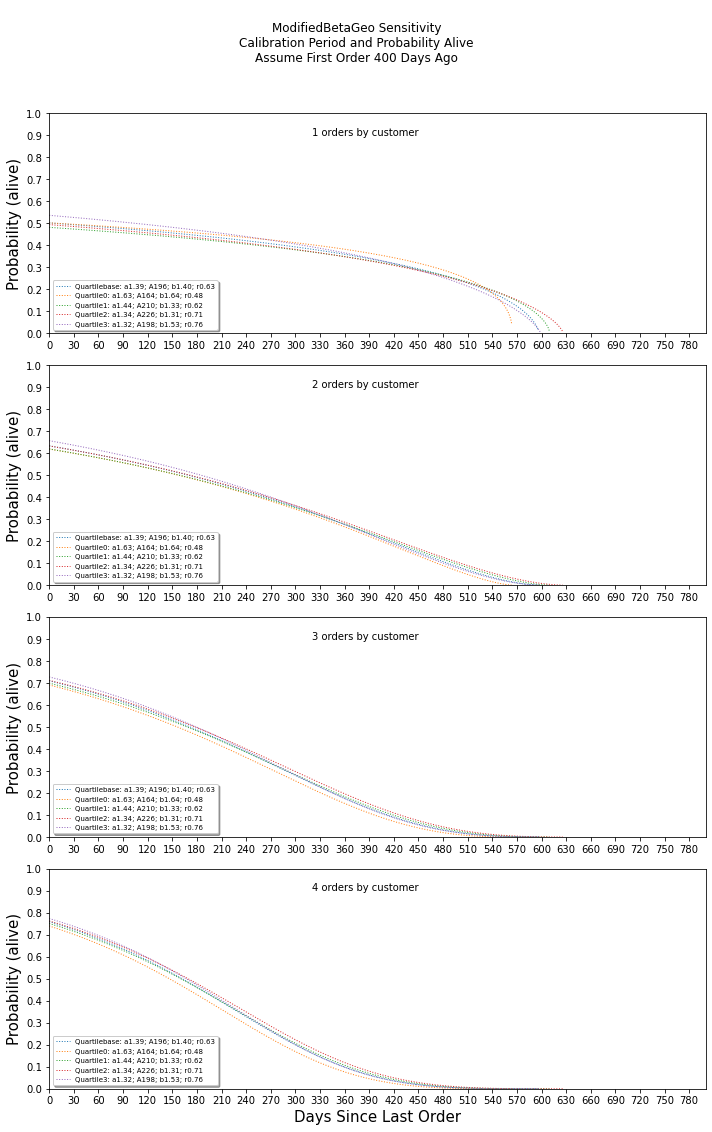

..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))
..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))
..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))
..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))
..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((al

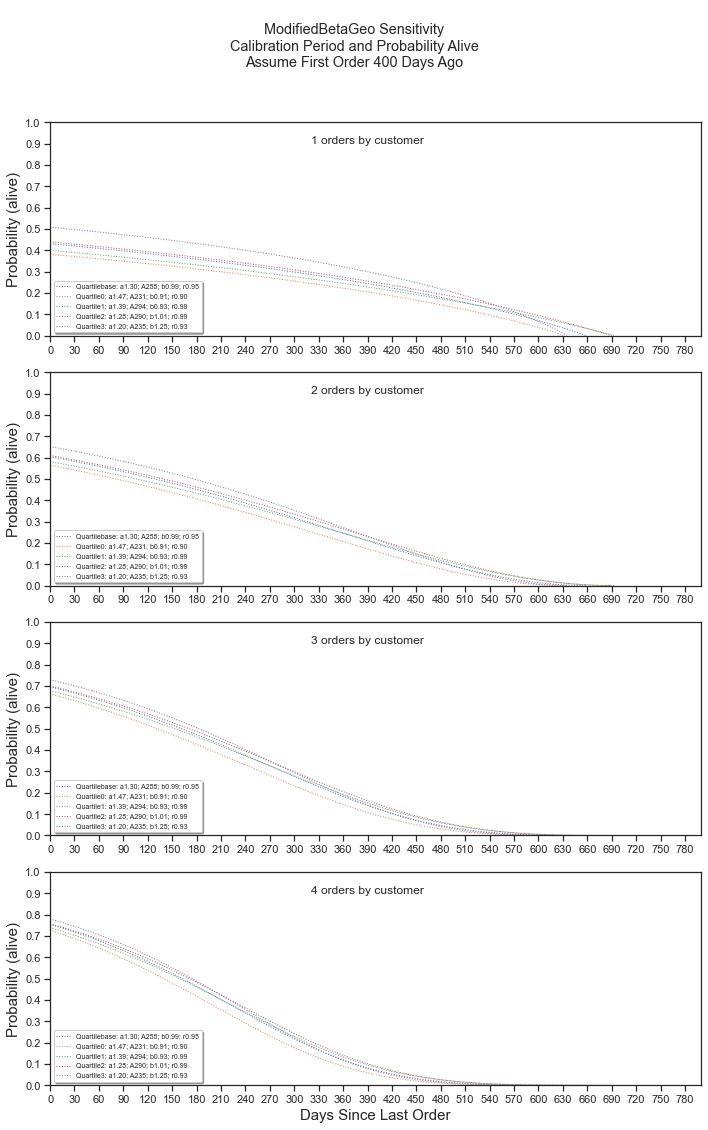

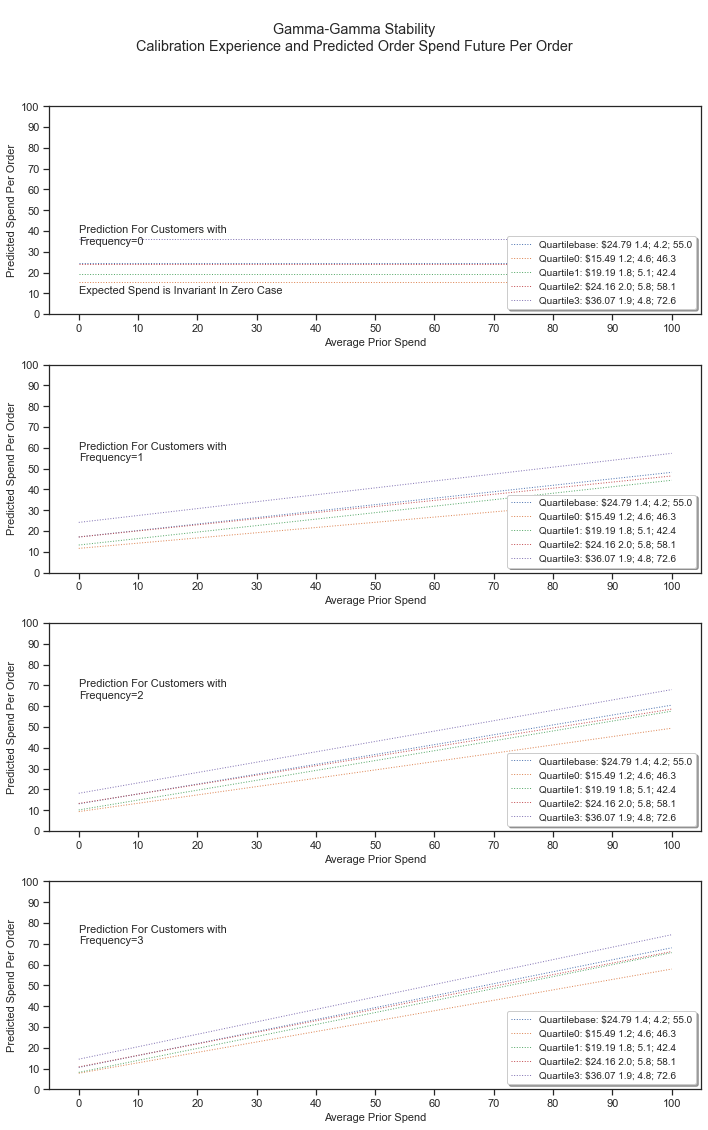

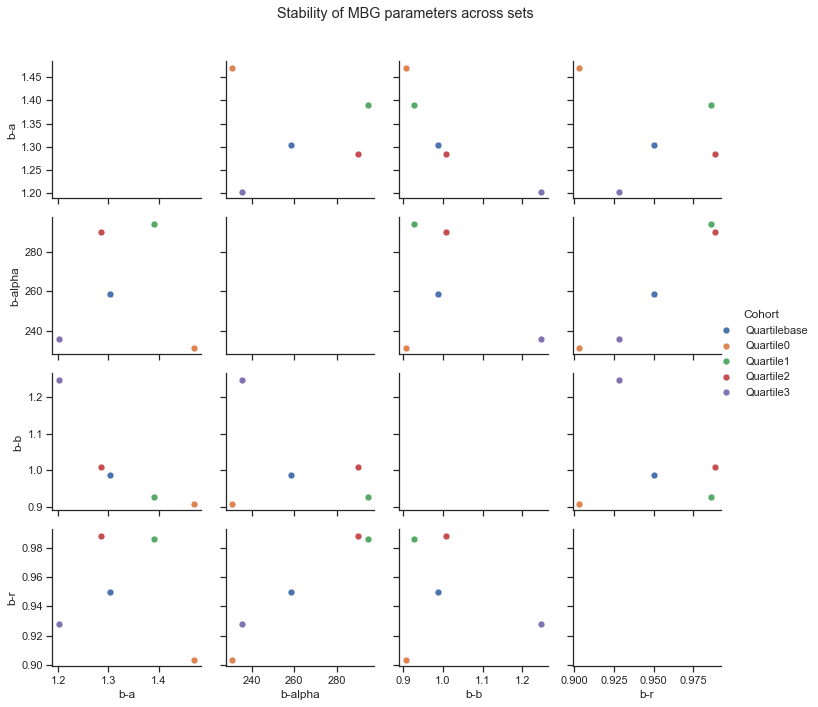

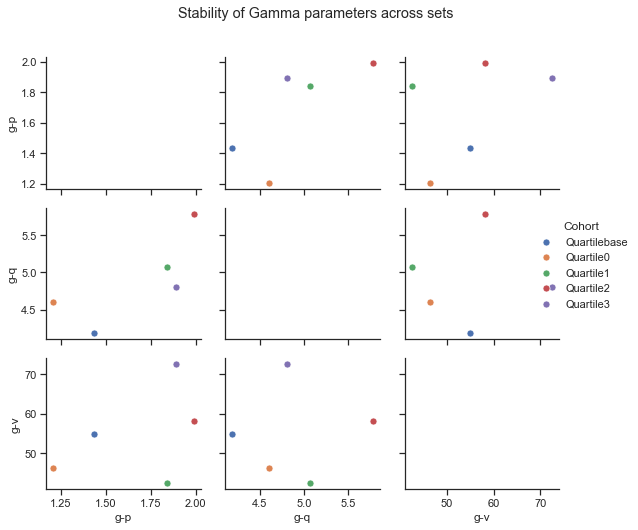

In [7]:
for country in countries:
    subset_df = results_df[results_df.country==country]
    subset_df['Cohort'] = 'Quartile' + subset_df['cohort']  # label of legend will be Cohort
    subset_df.loc[subset_df.Cohort=='CQbase', 'Cohort'] = 'All'
    VPLifetimesHoldoutPlots.plot_beta_sensitivity_sets(subset_df, 'Cohort', max_frequency=4)
    plt.show()
    VPLifetimesHoldoutPlots.plot_gamma_gamma_sensitivity_sets(subset_df, 'Cohort')
    plt.show()
    beta_vars = ['Cohort', 'b-a', 'b-alpha', 'b-b', 'b-r']
    gamma_vars = ['Cohort', 'g-p', 'g-q', 'g-v']
    VPLifetimesHoldoutPlots.plot_parameter_stability_pairplot(subset_df[beta_vars], 'Cohort',
                                                              plot_title='Stability of MBG parameters across sets')
    plt.show()
    VPLifetimesHoldoutPlots.plot_parameter_stability_pairplot(subset_df[gamma_vars], 'Cohort',
                                                             plot_title='Stability of Gamma parameters across sets')
    plt.show()

In [8]:
compare_df

country                   cohort  start_date    obs_date  \
6      ES                        0  2010-07-01  2020-08-01   
7      ES                        1  2010-07-01  2020-08-01   
8      ES                        2  2010-07-01  2020-08-01   
9      ES                        3  2010-07-01  2020-08-01   
1      ES  agp_quartiles: combined  2010-07-01  2020-08-01   
5      ES                     base  2010-07-01  2020-08-01   
1      IE                        0  2010-07-01  2020-08-01   
2      IE                        1  2010-07-01  2020-08-01   
3      IE                        2  2010-07-01  2020-08-01   
4      IE                        3  2010-07-01  2020-08-01   
0      IE  agp_quartiles: combined  2010-07-01  2020-08-01   
0      IE                     base  2010-07-01  2020-08-01   

  calibration_period_end  num_shoppers  numorder_mae  numorder_rmse  \
6             2019-09-30        228133      0.060159       0.215932   
7             2019-09-30        222979      0.093305       0.269935   
8             2019-09-30        222591      0.113091       0.320513   
9             2019-09-30        222564      0.137655       0.367634   
1             2019-09-30        896267      0.100795       0.298448   
5             2019-09-30        896267      0.100308       0.298353   
1             2019-09-30         88234      0.097695       0.285367   
2             2019-09-30         85687      0.113071       0.306750   
3             2019-09-30         86759      0.120063       0.319592   
4             2019-09-30         87494      0.137888       0.378231   
0             2019-09-30        348174      0.117153       0.324339   
0             2019-09-30        348174      0.117511       0.324480   

   numorder_predicted_orders  numorder_actual_orders  \
6               10225.716625                  9153.0   
7               15084.233393                 13361.0   
8               19133.813770                 16537.0   
9               25100.324738                 21318.0   
1               69544.088526                 60369.0   
5               68791.108711                 60369.0   
1                6387.603830                  4249.0   
2                7346.754198                  4947.0   
3                8261.711124                  5491.0   
4               10041.407807                  6793.0   
0               32037.476959                 21480.0   
0               32134.972801                 21480.0   

   numorder_predicted_per_customer  numorder_actual_per_customer  \
6                         0.044823                      0.040121   
7                         0.067649                      0.059920   
8                         0.085960                      0.074293   
9                         0.112778                      0.095784   
1                         0.077593                      0.067356   
5                         0.076753                      0.067356   
1                         0.072394                      0.048156   
2                         0.085739                      0.057733   
3                         0.095226                      0.063290   
4                         0.114767                      0.077640   
0                         0.092016                      0.061693   
0                         0.092296                      0.061693   

   numorder_rspearman  mval_mae  mval_rmse  mval_predicted   mval_actual  \
6            0.251363  0.928722   4.403427    1.788538e+05  1.220299e+05   
7            0.287301  1.660693   6.346458    3.142281e+05  1.931584e+05   
8            0.308330  2.510726   9.825928    4.917066e+05  2.837912e+05   
9            0.344344  4.536454  16.815224    9.615625e+05  4.960385e+05   
1            0.303696  2.399607  10.447397    1.946351e+06  1.095018e+06   
5            0.303395  2.352187  10.291491    1.879914e+06  1.095018e+06   
1            0.203061  2.012733   7.156351    1.503334e+05  7.069004e+04   
2            0.227216  2.595337   7.942949    1.9

## Gamma-Gamma Charts

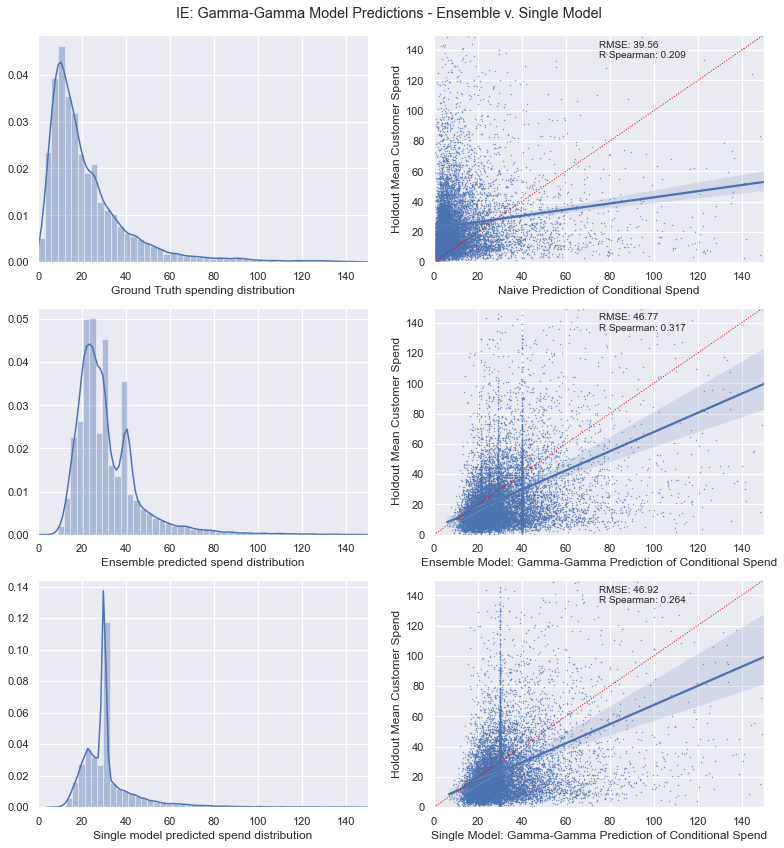

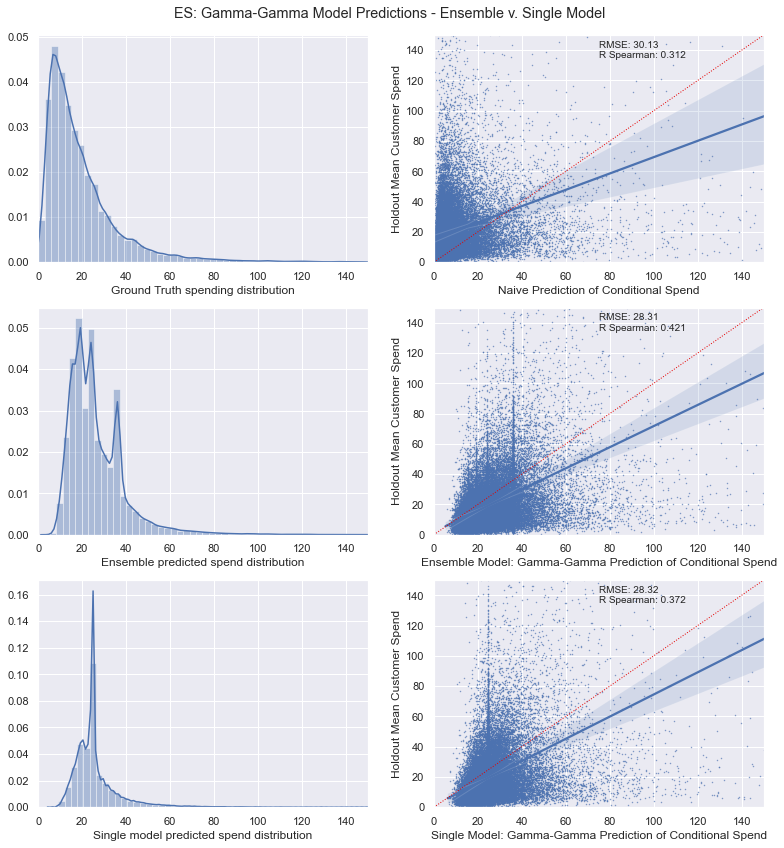

In [9]:
max_spend = 150
for country in countries:
    country_df = country_combined[country]
    purchasers = country_df[country_df.frequency_holdout > 0].copy()
    purchasers['naive_mon_avg'] =  purchasers.monetary_value_cal.div(purchasers.frequency_cal)
    purchasers['holdout_mon_avg'] = purchasers.monetary_value_holdout.div(purchasers.frequency_holdout)
    purchasers['predict_mon_avg'] = purchasers.predict_total_spend.div(purchasers.predict_order_count)

    sns.set_style("darkgrid")
    fig, axes = plt.subplots(3, 2, figsize=(13,13))
    # kde and hist work out better when drawn over limited range
    valid=purchasers[purchasers.holdout_mon_avg < max_spend]
    ax = sns.distplot(valid.holdout_mon_avg, ax=axes[0,0])
    ax.set_xlim(0, max_spend)
    ax.set_xlabel('Ground Truth spending distribution')

    ax = VPLifetimesHoldoutPlots.plot_exp_spend_accuracy_scatter(purchasers,
                                   'Naive Prediction of Conditional Spend',
                                   'naive_mon_avg',
                                   'holdout_mon_avg',
                                    max_spend=150,
                                    annotation_font_size=10,
                                    ax=axes[0, 1])
    # Ensemble model
    valid=purchasers[purchasers.predict_mon_avg < max_spend]
    ax = sns.distplot(valid.predict_mon_avg, ax=axes[1,0])
    ax.set_xlim(0, max_spend)
    ax.set_xlabel('Ensemble predicted spend distribution')

    
    
    ax = VPLifetimesHoldoutPlots.plot_exp_spend_accuracy_scatter(purchasers,
                                   'Ensemble Model: Gamma-Gamma Prediction of Conditional Spend',
                                   'predict_mon_avg',
                                   'holdout_mon_avg',
                                    max_spend=150,
                                    annotation_font_size=10,
                                    ax=axes[1, 1])
    

    country_df = base_dfs[country]
    purchasers = country_df[country_df.frequency_holdout > 0].copy()
    purchasers['naive_mon_avg'] =  purchasers.monetary_value_cal.div(purchasers.frequency_cal)
    purchasers['holdout_mon_avg'] = purchasers.monetary_value_holdout.div(purchasers.frequency_holdout)
    purchasers['predict_mon_avg'] = purchasers.predict_total_spend.div(purchasers.predict_order_count)
        
    # Single model
    valid=purchasers[purchasers.predict_mon_avg < max_spend]
    ax = sns.distplot(valid.predict_mon_avg, ax=axes[2,0])
    ax.set_xlim(0, max_spend)
    ax.set_xlabel('Single model predicted spend distribution')

    ax = VPLifetimesHoldoutPlots.plot_exp_spend_accuracy_scatter(purchasers,
                                   'Single Model: Gamma-Gamma Prediction of Conditional Spend',
                                   'predict_mon_avg',
                                   'holdout_mon_avg',
                                    max_spend=150,
                                    annotation_font_size=10,
                                    ax=axes[2, 1])
    
    plt.subplots_adjust(top=0.95)
    plt.suptitle(f'{country}: Gamma-Gamma Model Predictions - Ensemble v. Single Model')
    plt.show()